In [2]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split as tts
from sklearn import decomposition, ensemble
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
import nltk

/Users/avyactjain/workspace/kaggle_nlp/.DS_Store
/Users/avyactjain/workspace/kaggle_nlp/multi_input_and_output_model.png
/Users/avyactjain/workspace/kaggle_nlp/test.csv
/Users/avyactjain/workspace/kaggle_nlp/nlp-with-disaster-tweets-Multi-Input-Neural-Network.ipynb
/Users/avyactjain/workspace/kaggle_nlp/train.csv
/Users/avyactjain/workspace/kaggle_nlp/.ipynb_checkpoints/Baseline models-checkpoint.ipynb
/Users/avyactjain/workspace/kaggle_nlp/.ipynb_checkpoints/baseline-models-checkpoint.ipynb
/Users/avyactjain/workspace/kaggle_nlp/.ipynb_checkpoints/NLP_M1-checkpoint.ipynb
/Users/avyactjain/workspace/kaggle_nlp/.ipynb_checkpoints/nlp-with-disaster-tweets-Multi-Input-Neural-Network-checkpoint.ipynb
/Users/avyactjain/workspace/kaggle_nlp/.ipynb_checkpoints/Kaggle 100% Accuracy-checkpoint.ipynb


In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Exploratory Data Analysis (EDA)
##### Columns
- id : a unique identifier for each tweet
- text : the text of the tweet
- location : the location the tweet was sent from (may be blank)
- keyword : a particular keyword from the tweet (may be blank)
- target : in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [5]:
print('Training data shape (rows, cols): ', df_train.shape)
df_train.head()

Training data shape (rows, cols):  (7613, 5)


id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [6]:
# keyword and location columns have some nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
print('Test data shape (rows, cols): ', df_test.shape)
df_test.head()

Test data shape (rows, cols):  (3263, 4)


id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [8]:
# keyword and location columns have some nulls
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
# Null check
df_train['keyword'].isnull().value_counts() / df_train.shape[0]

False    0.991987
True     0.008013
Name: keyword, dtype: float64

In [10]:
df_train['location'].isnull().value_counts() / df_train.shape[0]

False    0.66728
True     0.33272
Name: location, dtype: float64

In [11]:
df_train['text'].isnull().value_counts() / df_train.shape[0]

False    1.0
Name: text, dtype: float64

In [12]:
df_test['keyword'].isnull().value_counts() / df_test.shape[0]

False    0.992032
True     0.007968
Name: keyword, dtype: float64

In [13]:
df_test['location'].isnull().value_counts() / df_test.shape[0]

False    0.661355
True     0.338645
Name: location, dtype: float64

In [14]:
df_test['text'].isnull().value_counts() / df_test.shape[0]

False    1.0
Name: text, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

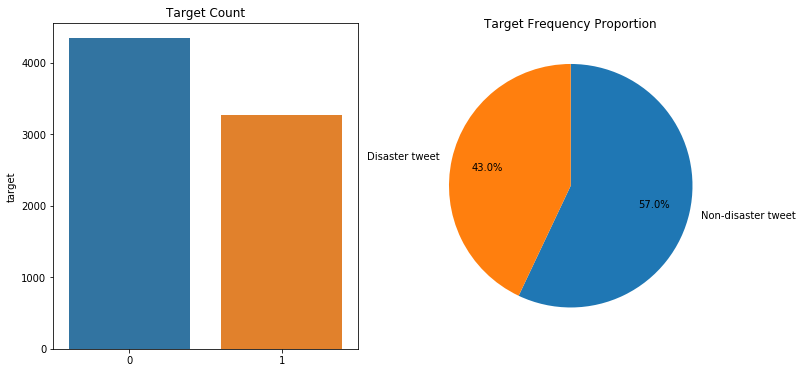

In [15]:
# Target Distribution (0 or 1)
dist_class = df_train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Target Frequency Proportion")
plt.show

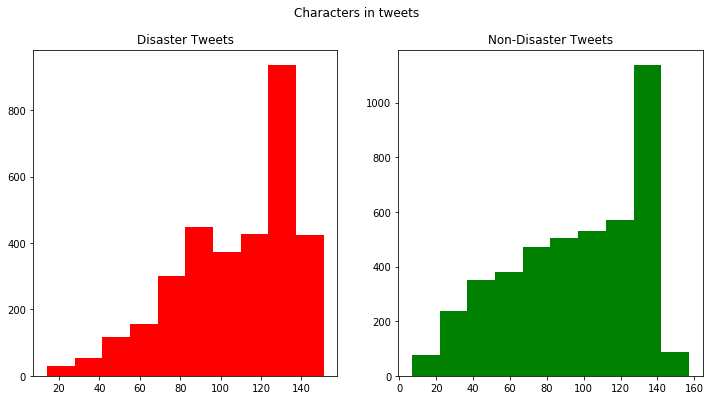

In [16]:
disaster_tweet_length = df_train[df_train['target']==1]['text'].str.len()
nondisaster_tweet_length = df_train[df_train['target']==0]['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_length, color='red')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_length, color='green')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Characters in tweets")
plt.show()

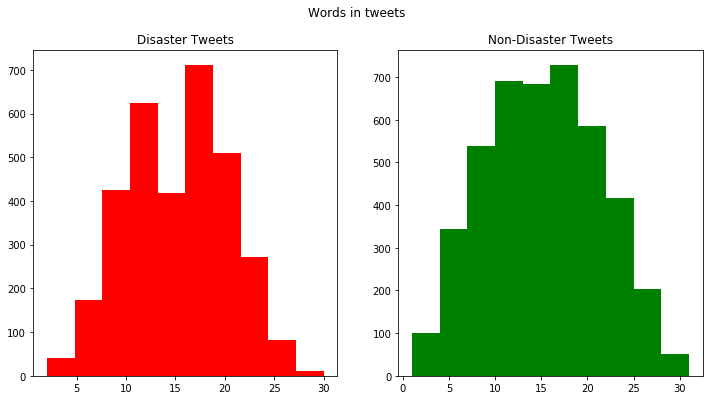

In [17]:
disaster_tweet_words = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
nondisaster_tweet_words = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_words, color='red')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_words, color='green')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Words in tweets")
plt.show()

In [18]:
df_train_keyword = pd.DataFrame({
    'keyword': df_train['keyword'].value_counts().index,
    'count': df_train['keyword'].value_counts().values
})

df_train_location = pd.DataFrame({
    'location': df_train['location'].value_counts().index,
    'count': df_train['location'].value_counts().values
})


print('Number fo unique keywords in training data: ', df_train_keyword.shape[0])

px.bar(
    df_train_keyword,
    x='keyword',
    y='count',
    title="Each unique keyword count in training data"
).show()

px.bar(
    df_train_location,
    x=df_train_location['location'][:20],
    y=df_train_location['count'][:20],
    title="Top 20 location countin training data"
).show()

Number fo unique keywords in training data:  221


In [19]:
df_train[df_train['target'] == 1]['keyword'].value_counts()

wreckage       39
derailment     39
outbreak       39
typhoon        37
oil%20spill    37
               ..
epicentre       1
body%20bag      1
blazing         1
body%20bags     1
ruin            1
Name: keyword, Length: 220, dtype: int64

In [20]:
df_train[df_train['target'] == 0]['keyword'].value_counts()

body%20bags          40
armageddon           37
harm                 37
wrecked              36
deluge               36
                     ..
oil%20spill           1
suicide%20bombing     1
outbreak              1
typhoon               1
suicide%20bomber      1
Name: keyword, Length: 218, dtype: int64

In [21]:
df_train[df_train['target'] == 1]['location'].value_counts()

USA                             67
United States                   27
Nigeria                         22
India                           20
Mumbai                          19
                                ..
Greenville, S.C.                 1
Middle Earth / Asgard / Berk     1
Ikeja, Nigeria                   1
Manhattan, NY                    1
Tipperary (Long Way)             1
Name: location, Length: 1513, dtype: int64

In [22]:
df_train[df_train['target'] == 0]['location'].value_counts()

New York                      55
USA                           37
London                        29
United States                 23
Los Angeles, CA               18
                              ..
Nigeria, WORLDWIDE             1
Detroit Tigers Dugout          1
Wood Buffalo, Alberta          1
Right here                     1
Beautiful British Columbia     1
Name: location, Length: 2142, dtype: int64

In [23]:
df_test_keyword = pd.DataFrame({
    'keyword': df_test['keyword'].value_counts().index,
    'count': df_test['keyword'].value_counts().values
})

df_test_location = pd.DataFrame({
    'location': df_test['location'].value_counts().index,
    'count': df_test['location'].value_counts().values
})

print('Number fo unique keywords in test data: ', df_test_keyword.shape[0])

px.bar(
    df_test_keyword,
    x='keyword',
    y='count',
    title="Each unique keyword count in test data"
).show()

px.bar(
    df_test_location,
    x=df_test_location['location'][:20],
    y=df_test_location['count'][:20],
    title="Top 20 location count in test data"
).show()

Number fo unique keywords in test data:  221


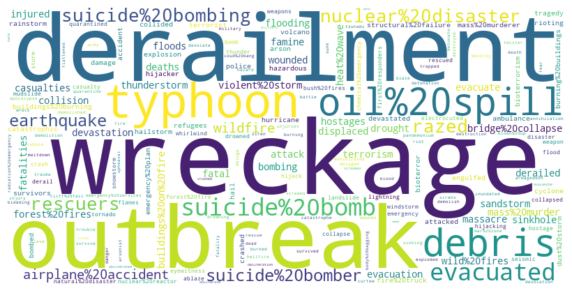

In [24]:
disaster_tweet = dict(df_train[df_train['target']==1]['keyword'].value_counts())

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(disaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

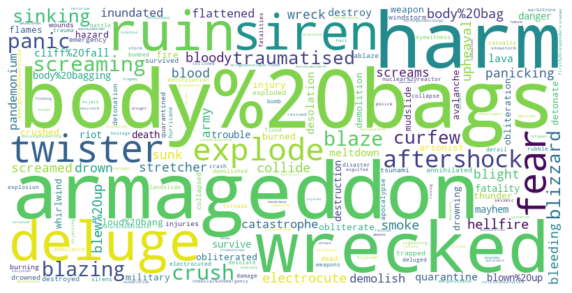

In [25]:
nondisaster_tweet = dict(df_train[df_train['target']==0]['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(nondisaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

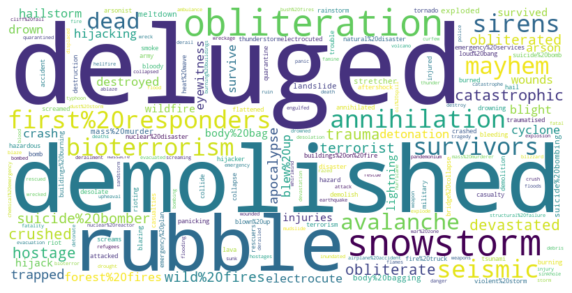

In [26]:
test_tweet = dict(df_test['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(test_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering (Data Cleaning? Data Pre-Processing?)

In [27]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

import string
def remove_punc(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [28]:
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text

In [29]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text


In [30]:
for datas in [df_train,df_test]:
    cleaned_text_list = []
    cleaned_keyword_list = []
    cleaned_location_list = []
    
    for index,row in datas.iterrows():
        if(row["text"]):
            cleaned_text = remove_url(row["text"])
            cleaned_text = remove_html(cleaned_text)
            cleaned_text = remove_emoji(cleaned_text)
            cleaned_text = unslang(cleaned_text)
            cleaned_text = remove_punc(cleaned_text)
            cleaned_text = tokenization(cleaned_text.lower())
            cleaned_text = remove_stopwords(cleaned_text)
            cleaned_text = stemming(cleaned_text)
            cleaned_text = " ".join(cleaned_text)
            
            cleaned_text_list.append(cleaned_text)

            
        
    datas["cleaned_text"] = cleaned_text_list

In [31]:
df_train.head(10)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target                                       cleaned_text  
0       1          deed reason earthquak may allah forgiv us  
1       1               forest fire near la rong sask canada  
2       1  resid ask shelter place notifi offic evacu she...  
3       1  13000 peopl receiv wildfir evacu order califor...  
4       1  got sent photo rubi alaska smoke wildfir pour ...  
5       1  rockyfir updat california hwi 20 close direct ...  
6       1  flood disast heavi rain caus flash flood stree...  
7       1                          im top hill see fire wood  
8       1       there emerg evacu happen build across street  
9       1                        im afraid tornado come area

In [32]:
df_train['text'][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [33]:
df_train['cleaned_text'][100]

'norwaymfa bahrain polic previous die road accid kill explos '

In [34]:
df_test.head(10)

id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   
5  12     NaN      NaN                 We're shaking...It's an earthquake   
6  21     NaN      NaN  They'd probably still show more life than Arse...   
7  22     NaN      NaN                                  Hey! How are you?   
8  27     NaN      NaN                                   What a nice hat?   
9  29     NaN      NaN                                          Fuck off!   

                                        cleaned_text  
0                           happen terribl car crash  
1      heard earthquak differ citi stay safe everyon  
2  forest fire spot pond gees flee across street ...  
3                     apocalyps light spokan wildfir  
4              typhoon soudelor kill 28 china taiwan  
5                                shakingit earthquak  
6  theyd probabl still show life arsen yesterday ...  
7                                                hey  
8                                           nice hat  
9                                               fuck

In [35]:
df_test['text'][100]

'BROOO HE JUST GOT ANNIHILATED https://t.co/UR7QkqG1wf'

In [36]:
df_test['cleaned_text'][100]

'brooo got annihil '

In [37]:
df_train = pd.get_dummies(df_train, columns=["keyword"], drop_first=True)

In [38]:
df_test  = pd.get_dummies(df_test, columns=["keyword"], drop_first=True)

In [39]:
df_train.drop(columns=["location", "text"], axis = 1, inplace = True)

In [40]:
df_train.head(10)

id  target                                       cleaned_text  \
0   1       1          deed reason earthquak may allah forgiv us   
1   4       1               forest fire near la rong sask canada   
2   5       1  resid ask shelter place notifi offic evacu she...   
3   6       1  13000 peopl receiv wildfir evacu order califor...   
4   7       1  got sent photo rubi alaska smoke wildfir pour ...   
5   8       1  rockyfir updat california hwi 20 close direct ...   
6  10       1  flood disast heavi rain caus flash flood stree...   
7  13       1                          im top hill see fire wood   
8  14       1       there emerg evacu happen build across street   
9  15       1                        im afraid tornado come area   

   keyword_accident  keyword_aftershock  keyword_airplane%20accident  \
0                 0                   0                            0   
1                 0                   0                            0   
2                 0                   0                            0   
3                 0                   0                            0   
4                 0                   0                            0   
5                 0                   0                            0   
6                 0                   0                            0   
7                 0                   0                            0   
8                 0                   0                            0   
9                 0                   0                            0   

   keyword_ambulance  keyword_annihilated  keyword_annihilation  \
0                  0                    0                     0   
1                  0                    0                     0   
2                  0                    0                     0   
3                  0                    0                     0   
4                  0                    0                     0   
5                  0                    0                     0   
6                  0                    0                     0   
7                  0                    0                     0   
8                  0                    0                     0   
9                  0                    0                     0   

   keyword_apocalypse  ...  keyword_weapons  keyword_whirlwind  \
0                   0  ...                0                  0   
1                   0  ...                0                  0   
2                   0  ...                0                  0   
3                   0  ...                0                  0   
4                   0  ...                0                  0   
5                   0  ...                0                  0   
6                   0  ...                0                  0   
7                   0  ...                0                  0   
8                   0  ...                0                  0   
9                   0  ...                0                  0   

   keyword_wild%20fires  keyword_wildfire  keyword_windstorm  keyword_wounded  \
0                     0                 0                  0                0   
1                     0                 0                  0                0   
2                     0                 0                  0                0   
3                     0                 0                  0                0   
4                     0                 0                  0                0   
5                     0                 0                  0                0   
6                     0                 0                  0                0   
7                     0                 0                  0                0   
8                     0                 0                  0                0   
9                     0                 0                  0                0   

   keyword_wounds  keyword_wreck  keyword_wreckage  keyword_wrecked  
0               0              0  

In [41]:
df_test.head()

id location                                               text  \
0   0      NaN                 Just happened a terrible car crash   
1   2      NaN  Heard about #earthquake is different cities, s...   
2   3      NaN  there is a forest fire at spot pond, geese are...   
3   9      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                        cleaned_text  keyword_accident  \
0                           happen terribl car crash                 0   
1      heard earthquak differ citi stay safe everyon                 0   
2  forest fire spot pond gees flee across street ...                 0   
3                     apocalyps light spokan wildfir                 0   
4              typhoon soudelor kill 28 china taiwan                 0   

   keyword_aftershock  keyword_airplane%20accident  keyword_ambulance  \
0                   0                            0                  0   
1                   0                            0                  0   
2                   0                            0                  0   
3                   0                            0                  0   
4                   0                            0                  0   

   keyword_annihilated  keyword_annihilation  ...  keyword_weapons  \
0                    0                     0  ...                0   
1                    0                     0  ...                0   
2                    0                     0  ...                0   
3                    0                     0  ...                0   
4                    0                     0  ...                0   

   keyword_whirlwind  keyword_wild%20fires  keyword_wildfire  \
0                  0                     0                 0   
1                  0                     0                 0   
2                  0                     0                 0   
3                  0                     0                 0   
4                  0                     0                 0   

   keyword_windstorm  keyword_wounded  keyword_wounds  keyword_wreck  \
0                  0                0               0              0   
1                  0                0               0              0   
2                  0                0               0              0   
3                  0                0               0              0   
4                  0                0               0              0   

   keyword_wreckage  keyword_wrecked  
0                 0                0  
1                 0                0  
2                 0                0  
3                 0                0  
4                 0                0  

[5 rows x 224 columns]

## Modeling and Evaluation

Trying a Multi Input and Single Output neural deep neural network. Multiple inputs being TF-IDF of text and one hot encoded keywords.

In [42]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=64)
vectorizer.fit(df_train['cleaned_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=64,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [43]:
X = df_train.drop(columns=["target"])
y = df_train["target"].values

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [45]:
text_data_train = vectorizer.transform(X_train['cleaned_text']).todense()
text_data_valid = vectorizer.transform(X_valid['cleaned_text']).todense()

keyword_data_train = (X_train.drop(["cleaned_text", "id"],axis = 1).values)
keyword_data_valid = (X_valid.drop(["cleaned_text", "id"],axis = 1).values)

text_data_train = np.asarray(text_data_train)
text_data_valid = np.asanyarray(text_data_valid)
keyword_data_train = np.asarray(keyword_data_train)
keyword_data_valid = np.asarray(keyword_data_valid)

In [46]:
num_keywords = 220  # Number of unique issue tags
num_words = 64  # Size of vocabulary specified when preprocessing text data
num_classes = 1 

body_input = keras.Input(shape=(None,), name='text')  # Variable-length sequence of ints
keywords_input = keras.Input(shape=(num_keywords,), name='keywords')  # Binary vectors of size `num_keywords`

# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words + 1, 64)(body_input)

# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([body_features, keywords_input])
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu", name = "hiddenlayer")(x)

# Stick a logistic regression for priority prediction on top of the features
# Stick a department classifier on top of the features
class_pred = layers.Dense(num_classes, activation='sigmoid', name='classes')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[body_input, keywords_input],
                    outputs=[class_pred])

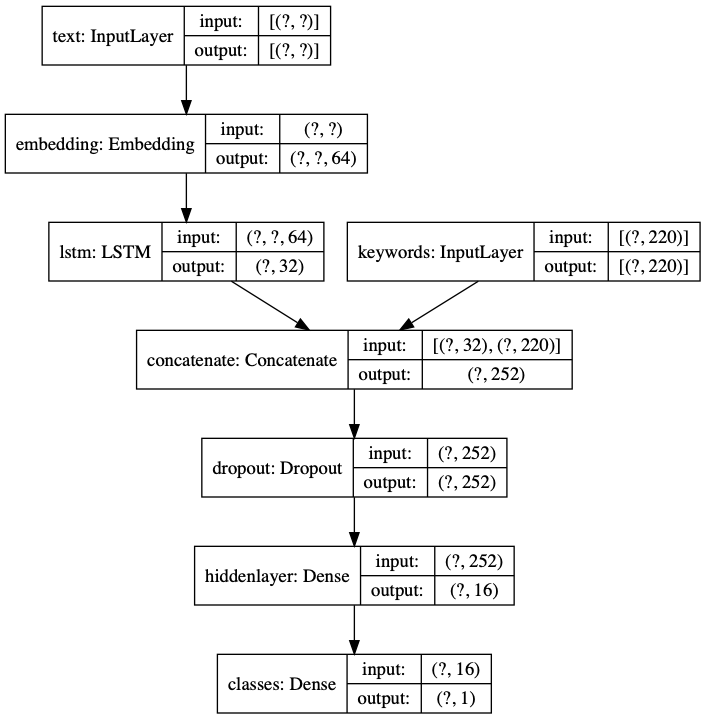

In [47]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [48]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss={
                    'classes': 'binary_crossentropy'},)

In [49]:
model.fit({'text': text_data_train, 'keywords':keyword_data_train },
          {'classes':(y_train)},
          epochs=20,
          batch_size=128)

Train on 5329 samples
Epoch 1/20
5329/5329 [==============================] - 4s 804us/sample - loss: 0.6822
Epoch 2/20
5329/5329 [==============================] - 2s 309us/sample - loss: 0.6685
Epoch 3/20
5329/5329 [==============================] - 2s 295us/sample - loss: 0.6543
Epoch 4/20
5329/5329 [==============================] - 2s 289us/sample - loss: 0.6347
Epoch 5/20
5329/5329 [==============================] - 2s 451us/sample - loss: 0.6135
Epoch 6/20
5329/5329 [==============================] - 2s 359us/sample - loss: 0.5941
Epoch 7/20
5329/5329 [==============================] - 2s 297us/sample - loss: 0.5829
Epoch 8/20
5329/5329 [==============================] - 2s 298us/sample - loss: 0.5712
Epoch 9/20
5329/5329 [==============================] - 2s 294us/sample - loss: 0.5637
Epoch 10/20
5329/5329 [==============================] - 2s 302us/sample - loss: 0.5575
Epoch 11/20
5329/5329 [==============================] - 2s 300us/sample - loss: 0.5581
Epoch 12/20
5329/53

In [50]:
predictions  = model.predict({'text': text_data_valid, 'keywords': keyword_data_valid.astype(np.float32)})

In [51]:
prediction_list = []
for prediction in predictions:
    if prediction >= 0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

In [52]:
print(metrics.accuracy_score(prediction_list, y_valid))

0.7263572679509632


## Submission
If you liked this kernel.. Please Upvote :)

In [53]:
text_data_test = vectorizer.transform(df_test['cleaned_text']).todense()
keyword_data_test = (df_test.drop(["cleaned_text", "id", "location","text"],axis = 1).values)

In [54]:
y_test_pred  = model.predict({'text': text_data_test, 'keywords': keyword_data_test.astype(np.float32)})

In [55]:
y_test_pred_list = []
for prediction in y_test_pred:
    if prediction >= 0.5:
        y_test_pred_list.append(1)
    else:
        y_test_pred_list.append(0)

In [56]:
submission_file = pd.DataFrame({'id': df_test['id'], 'target': y_test_pred_list})

In [57]:
submission_file.to_csv("submission.csv")